In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from PIL import Image
import os
import torchvision
from torchvision import transforms as tvt
import torch
from torch.nn import parallel
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pathlib
import random
import skimage
import cv2
from torchvision import ops

In [ ]:
!unzip /content/instances_train2014.json.zip -d /content/
!unzip /content/instances_val2014.json.zip -d /content/
!unzip /content/val_resized.zip -d /content
!unzip /content/train_resized.zip -d /content
print(os.getcwd())
root = "."
dataType='train2014'
annFile=  'instances_{}.json'.format(dataType)

### Mapping from COCO label to Class indices ###
coco_labels_inverse = {}
coco = COCO(annFile)

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/train_resized/._COCO_train2014_000000090151.jpg  
  inflating: /content/train_resized/COCO_train2014_000000422272.jpg  
  inflating: /content/__MACOSX/train_resized/._COCO_train2014_000000422272.jpg  
  inflating: /content/train_resized/COCO_train2014_000000304011.jpg  
  inflating: /content/__MACOSX/train_resized/._COCO_train2014_000000304011.jpg  
  inflating: /content/train_resized/COCO_train2014_000000026208.jpg  
  inflating: /content/__MACOSX/train_resized/._COCO_train2014_000000026208.jpg  
  inflating: /content/train_resized/COCO_train2014_000000078412.jpg  
  inflating: /content/__MACOSX/train_resized/._COCO_train2014_000000078412.jpg  
  inflating: /content/train_resized/COCO_train2014_000000354626.jpg  
  inflating: /content/__MACOSX/train_resized/._COCO_train2014_000000354626.jpg  
  inflating: /content/train_resized/COCO_train2014_000000494895.jpg  
  inflating: /content/__MACOSX/train_resize

In [ ]:
#Write a script that filters through images and annotations to generate your training and testing dataset
# such that ay image meets the following criteria: 1) contains at least one foreground object from bus, cat, pizza. 
# must be at least 64 x 64 = 4096 pixels. There can be multiple foreground objects, but, if there are none, we 
# can discard it. Once we have the images downloaded, resize them to 256 x 256 and also rescale the bbox params
# accordingly. 
class_list = ['bus', 'cat', 'pizza']

### PREPROCESSING TO GENERATE IMAGE UNIQUE IDS ###
catIds = coco.getCatIds(catNms = class_list)
imgIds = coco.getImgIds(catIds = catIds)
imgIds_list = []
for catId in catIds:
    imgIds_list.append(coco.getImgIds(catIds = catId))
concatenated_list = []
for x in imgIds_list:
    for y in x:
        concatenated_list.append(y)

np_li = np.array(concatenated_list)
unique_imgIds = np.unique(np_li) #make the list unique - there might be duplicate image ids

unique_imgIds = list(unique_imgIds) #convert numpy array back to list

for n, i in enumerate(unique_imgIds):
    unique_imgIds[n] = int(i) #convert each element of list to integer, so it can easily be interpretted by 
    #coco api
print(len(unique_imgIds)) #7799

7799


In [ ]:
data_dict_train = {}

#os.chdir("/Users/alim/Documents/ECE60146/hw6/")
for n, imgId in enumerate(unique_imgIds):
        annId = coco.getAnnIds(imgId, catIds=catIds, iscrowd=False)
        #now that we have the annotation id, we want to check if there is a dominant object. In order to get 
        #the details of that annotation id, we need to load the annotation using that id:
        annId_metadata = coco.loadAnns(annId)
        key = -1 #temp value for key that doesn't exist
        for ann in annId_metadata:
            [x, y, w, h] = ann['bbox']
            #print(ann)
            if ((ann['area'] <= 4096) or (w <= 64) or (h <= 64)):
                continue #do not consider looking at annotation details for that annId
            else: 
                #store this annotation:
                imgId_metadata = coco.loadImgs(imgId)
                key = imgId_metadata[0]['file_name']
                if (key in data_dict_train):
                    #we need to append to existing dictionary
                    data_dict_train[key].append({'ann_id' : ann['id'], 'bbox' : ann['bbox'], 'cat_id': ann['category_id'], 'url':imgId_metadata[0]['coco_url'],
                                    'img_id' : imgId_metadata[0]['id'], 'img_h' : imgId_metadata[0]['height'], 
                                   'img_w' : imgId_metadata[0]['width']})

                else:
                    #we need to create new dictionary key
                    data_dict_train[key] = [{'ann_id' : ann['id'], 'bbox' : ann['bbox'], 'cat_id': ann['category_id'], 'url':imgId_metadata[0]['coco_url'],
                                    'img_id' : imgId_metadata[0]['id'], 'img_h' : imgId_metadata[0]['height'], 
                                   'img_w' : imgId_metadata[0]['width']}]
                #download this image:
        #if (key != -1):
        #    coco.download(tarDir = 'train_orig/', imgIds = [data_dict_train[key][0]['img_id']])

#print('this is the data_dict:', data_dict_train)

###ORGANIZATION OF data_dict_train:
#key is file_name
#value is a list of elements.
#element 0: annotation id
#element 1: bbox
#element 2: category id
#element 3: img_id coco_url
#element 4: img_id
#element 5: img height
#element 6: img width
#print("imgId", imgId)
full_len = 0
print(len(data_dict_train)) #6712 images in training dataset
for k in data_dict_train:
    temp_len = len(data_dict_train[k])
    full_len += temp_len
print(full_len) #8343 annotations total

6712
8343


In [ ]:
dataType='val2014'
print(os.getcwd())
annFile= 'instances_{}.json'.format(dataType)

### Mapping from COCO label to Class indices ###
coco_labels_inverse = {}
coco = COCO(annFile)

#Write a script that filters through images and annotations to generate your training and testing dataset
# such that ay image meets the following criteria: 1) contains at least one foreground object from bus, cat, pizza. 
# must be at least 64 x 64 = 4096 pixels. There can be multiple foreground objects, but, if there are none, we 
# can discard it. Once we have the images downloaded, resize them to 256 x 256 and also rescale the bbox params
# accordingly. 
class_list = ['bus', 'cat', 'pizza']

### PREPROCESSING TO GENERATE IMAGE UNIQUE IDS ###
catIds = coco.getCatIds(catNms = class_list)
imgIds = coco.getImgIds(catIds = catIds)
imgIds_list = []
for catId in catIds:
    imgIds_list.append(coco.getImgIds(catIds = catId))
concatenated_list = []
for x in imgIds_list:
    for y in x:
        concatenated_list.append(y)

np_li = np.array(concatenated_list)
unique_imgIds = np.unique(np_li) #make the list unique - there might be duplicate image ids

unique_imgIds_test = list(unique_imgIds) #convert numpy array back to list

for n, i in enumerate(unique_imgIds_test):
    unique_imgIds_test[n] = int(i) #convert each element of list to integer, so it can easily be interpretted by 
    #coco api
print(len(unique_imgIds_test)) #3940

/content
loading annotations into memory...
Done (t=5.66s)
creating index...
index created!
3940


In [ ]:
data_dict_val = {}

#os.chdir("/Users/alim/Documents/ECE60146/hw6/")
for n, imgId in enumerate(unique_imgIds_test):
        annId = coco.getAnnIds(imgId, catIds=catIds, iscrowd=False)
        #now that we have the annotation id, we want to check if there is a dominant object. In order to get 
        #the details of that annotation id, we need to load the annotation using that id:
        annId_metadata = coco.loadAnns(annId)
        key = -1 #temp value for key that doesn't exist
        for ann in annId_metadata:
            [x, y, w, h] = ann['bbox']
            #print(ann)
            if ((ann['area'] <= 4096) or (w <= 64) or (h <= 64)):
                continue #do not consider looking at annotation details for that annId
            else: 
                #store this annotation:
                imgId_metadata = coco.loadImgs(imgId)
                key = imgId_metadata[0]['file_name']
                if (key in data_dict_val):
                    #we need to append to existing dictionary
                    data_dict_val[key].append({'ann_id' : ann['id'], 'bbox' : ann['bbox'],'cat_id': ann['category_id'],
                                               'url':imgId_metadata[0]['coco_url'],
                                    'img_id' : imgId_metadata[0]['id'], 'img_h' : imgId_metadata[0]['height'], 
                                   'img_w' : imgId_metadata[0]['width']})

                else:
                    #we need to create new dictionary key
                    data_dict_val[key] = [{'ann_id' : ann['id'], 'bbox' : ann['bbox'], 'cat_id': ann['category_id'], 'url':imgId_metadata[0]['coco_url'],
                                    'img_id' : imgId_metadata[0]['id'], 'img_h' : imgId_metadata[0]['height'], 
                                   'img_w' : imgId_metadata[0]['width']}]
                #download this image:
        #if (key != -1):
        #    coco.download(tarDir = 'val_orig/', imgIds = [data_dict_val[key][0]['img_id']])

full_len = 0
print(len(data_dict_val)) #3427 images in val dataset
for k in data_dict_val:
    temp_len = len(data_dict_val[k])
    full_len += temp_len
print(full_len) #4198 annotations total in val dataset

3427
4198


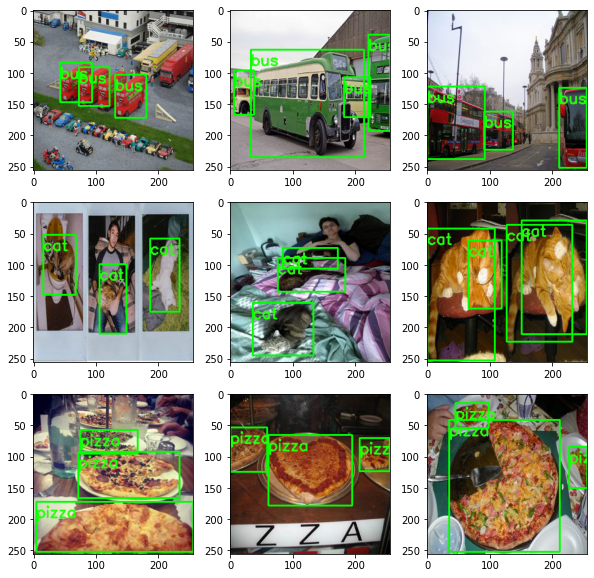

In [ ]:
### Print 3 x 3 plot of images with bounding boxes. 3 images from each class.

fig, ax = plt.subplots(3,3 ,figsize = (10,10))
count_bus = 0
count_cat = 0
count_pizza = 0
#root = '/Users/alim/Documents/ECE60146/hw6/'

for n, key in enumerate(data_dict_train):
        cat = data_dict_train[key][0]['cat_id']
        if (n > 3000) and (len(data_dict_train[key]) > 2):
        #print('cat is', cat)
            if (cat == 6) and (count_bus < 3):
                PIL_img = Image.open('train_resized/' + str(key))
                np_img = np.uint8(PIL_img)
                for i in range(len(data_dict_train[key])):
                    scaling_factor_x =  256.0 / data_dict_train[key][0]['img_w'] 
                    scaling_factor_y =  256.0 / data_dict_train[key][0]['img_h']
                    [x, y, w, h] = data_dict_train[key][i]['bbox']
                    np_img = cv2.rectangle(np_img, (int(x * scaling_factor_x), int(y*scaling_factor_y)), 
                                        (int((x+w)*scaling_factor_x), int((y+h)*scaling_factor_y)), (0,255,0), 2)
                    np_img = cv2.putText(np_img, "bus", (int(x * scaling_factor_x), int(y * scaling_factor_y + 25)), 
                                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255, 12),2)
                    ax[0, count_bus].imshow(np_img)            


                count_bus = count_bus + 1

            if (cat == 17) and (count_cat < 3):
                PIL_img = Image.open('train_resized/' + str(key))
                np_img = np.uint8(PIL_img)
                for i in range(len(data_dict_train[key])):
                    scaling_factor_x =  256.0 / data_dict_train[key][0]['img_w'] 
                    scaling_factor_y =  256.0 / data_dict_train[key][0]['img_h']
                    [x, y, w, h] = data_dict_train[key][i]['bbox']
                    np_img = cv2.rectangle(np_img, (int(x * scaling_factor_x), int(y*scaling_factor_y)), 
                                        (int((x+w)*scaling_factor_x), int((y+h)*scaling_factor_y)), (0,255,0), 2)
                    np_img = cv2.putText(np_img, "cat", (int(x * scaling_factor_x), int(y * scaling_factor_y + 25)), 
                                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255, 12),2)
                    ax[1, count_cat].imshow(np_img)    
                count_cat = count_cat + 1

            if (cat == 59) and (count_pizza < 3):
                PIL_img = Image.open('train_resized/' + str(key))
                np_img = np.uint8(PIL_img)
                for i in range(len(data_dict_train[key])):
                    scaling_factor_x =  256.0 / data_dict_train[key][0]['img_w'] 
                    scaling_factor_y =  256.0 / data_dict_train[key][0]['img_h']
                    [x, y, w, h] = data_dict_train[key][i]['bbox']
                    np_img = cv2.rectangle(np_img, (int(x * scaling_factor_x), int(y*scaling_factor_y)), 
                                        (int((x+w)*scaling_factor_x), int((y+h)*scaling_factor_y)), (0,255,0), 2)
                    np_img = cv2.putText(np_img, "pizza", (int(x * scaling_factor_x), int(y * scaling_factor_y + 25)), 
                                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (36,255, 12),2)
                    ax[2, count_pizza].imshow(np_img) 
                count_pizza = count_pizza + 1


In [ ]:
##### build the dataloader.

#root = '/Users/alim/Documents/ECE60146/hw6/'
folders = ['train_resized/', 'val_resized/']

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        super(MyDataset).__init__()
        #self.root = root
        self.folder = folder
        if (self.folder == 'train_resized/'):
            self.data_dict = data_dict_train
        if (self.folder == 'val_resized/'):
            self.data_dict = data_dict_val
        
        self.mapping = {6: 0, 17: 1, 59: 2}
        self.one_hot_encoding = {0: torch.tensor(np.array([1, 0, 0])),
                                1: torch.tensor(np.array([0, 1, 0])),
                                2: torch.tensor(np.array([0, 0, 1]))}
        self.images = os.listdir(folder) #create list of files in the train or val directory. We will use
        # this list to get bbox params, read image files, etc. 

        for img in self.images:
            if (img == ".DS_Store"):
                self.images.remove(".DS_Store") #handle case when image isn't an image. Just remove it from the 
                #image list. 
        
        self.to_Tensor_and_Norm = tvt.Compose([tvt.ToTensor(), tvt.Normalize([0], [1])])
        
        #find the image with the most objects, get that number of objects so we can create an empty list 
        # with that number of elements:
        self.max_obj_instances = 0 #this becomes 14 for train, 13 for val
        for key in self.data_dict:
            if len(self.data_dict[key]) > self.max_obj_instances:
                self.max_obj_instances = len(self.data_dict[key])
        self.cell_and_anchors_tracker = np.zeros((8, self.max_obj_instances)) -99 #instantiate to -99
        #tracker is a 3 x 14 matrix. Each col will hold data of an obj instance
        #row 1 and row 2 will be x,y idx of assigned cell
        #row 3 will be the assigned anchor box. The assignments will be made in the __getitem__ function
        #rows 4 to 7 will be the x,y,w,h (normalized to a 256 to 256 image)
        #row 8 is the class in terms of 0, 1, 2



    def __len__(self):
        return len(self.data_dict)
    
    def __getitem__(self, index):
        #prepare image:
        PIL_img = Image.open(self.folder + self.images[index])
        torch_img = self.to_Tensor_and_Norm(PIL_img)
        
        #prepare class labels
        li_class_labels = []
        for i in range(len(self.data_dict[self.images[index]])):
            #print(self.data_dict[self.images[index]])
            class_label = self.data_dict[self.images[index]][i]['cat_id']
            class_label = self.mapping[class_label]
            class_label = torch.tensor(class_label)
            li_class_labels.append(class_label)
        #for each object in the image, figure out which grid cell it belongs (i.e, cell which is closest)
        #to the center of the bbox.
        #will have a 8 by 8 grid cell, so, the yolo interval will be 256 / 8 = 32
        #get bbox center:
        yolo_interval = 32
        bbox_anchor_list = []
        yolo_tensor = torch.zeros(8,8,5,8)
        dict_assigned_yolo_vectors = {}
        
        for i in range(len(self.data_dict[self.images[index]])): #iterate through each object instance
            if i == 0: #start to print image for sanity check
                np_img = np.uint8(PIL_img)
                ticks = np.linspace(start = 0, stop = 256, num=9)

                
            [x, y, w, h] = self.data_dict[self.images[index]][i]['bbox']
            img_w = self.data_dict[self.images[index]][i]['img_w']
            img_h = self.data_dict[self.images[index]][i]['img_h']
            #scale x y w h in terms of a 256 x 256 image. 
            scaling_factor_x = 256.0 / img_w
            scaling_factor_y = 256.0 / img_h
            x = scaling_factor_x * x
            y = scaling_factor_y * y
            w = scaling_factor_x * w
            h = scaling_factor_y * h
            #done scaling original x, y, w, h parameters
 
            #find center of bbox
            cx_bbox = (x + x + w) / 2 #center of bbox (x coord)
            cy_bbox = (y + y + h) / 2 #center of bbox  (y coord)

            #find the yolo cell that the bbox belongs to:
            yolo_grid_x_idx = cx_bbox // yolo_interval
            yolo_grid_y_idx = cy_bbox // yolo_interval
            #find the exact yolo cell center coords. We will need this to compute dx, dy, the difference
            #between center of bbox and center of yolo grid
            yolo_grid_x_center = yolo_grid_x_idx * yolo_interval + (yolo_interval / 2)
            yolo_grid_y_center = yolo_grid_y_idx * yolo_interval + (yolo_interval / 2)
            
            #compute displacements between the center of the cell and the center of the bounding box in a 
            #training image for a given object instance (dx and dy)
            dx =  cx_bbox - yolo_grid_x_center 
            dy =  cy_bbox -  yolo_grid_y_center
            
            #plot bbox, center of yolo grid cell that was assigned, and center of bbox
            np_img = cv2.rectangle(np_img, (int(x), int(y)), 
                                (int((x+w)), int((y+h))), (0,255,0), 2)
            #image, center_coordinates, radius, color, thickness
            np_img = cv2.circle(np_img, (int(cx_bbox), int(cy_bbox)), 1, 
                                 (0,0,255),  5)
            np_img = cv2.circle(np_img, (int(yolo_grid_x_center), int(yolo_grid_y_center)), 1, (255, 0, 0), 4)
               
            #pick the correct anchor box. There are 5 anchor boxes with different aspect ratio:
            # 5 x 1, 3 x 1, 1 x 1, 1 x 3, 1 x 5
            #iou_box function in pytorch expects that coords are in [x1 y1 x2 y2] format.
            #we already know the bbox:
            GT_bbox_for_iou = torch.tensor([x, y, x+w, y+h]).view(1,4) #view reshapes to 1,4
            IOU_li = []
            anchor_box_options = [[5,1], [3,1], [1,1], [1,3], [1, 5]]
            for n, ab in enumerate(anchor_box_options):

                bbox_anchor_w = yolo_interval * ab[0]
                bbox_anchor_h = yolo_interval * ab[1]
                bbox_anchor = torch.tensor([yolo_grid_x_center, yolo_grid_y_center, bbox_anchor_w, bbox_anchor_h]).view(1,4)
                #above bbox_anchor is in cx,cy,w,h fmt
                bbox_anchor = ops.box_convert(bbox_anchor, in_fmt = 'cxcywh', out_fmt = 'xyxy')
                bbox_anchor = torch.clamp(bbox_anchor, 0, 256)
                bbox_anchor_list.append(bbox_anchor)

                np_img = cv2.rectangle(np_img, (int(bbox_anchor_list[n+(5*i)][0][0]), int(bbox_anchor_list[n+(5*i)][0][1])), (int(bbox_anchor_list[n+(5*i)][0][2]),
                                     int(bbox_anchor_list[n+(5*i)][0][3])), (0, 255, 255), 1)

                IOU = ops.box_iou(GT_bbox_for_iou, bbox_anchor)
                IOU_li.append(IOU)
                if n == 4:
                    temp_arr = np.empty(5)
                    for k, iou in enumerate(IOU_li):
                        temp_arr[k] = iou.view(-1).item() #put computed IOUs into nparray format so we can perform argmax
                    max_IOU_idx = np.argmax(temp_arr)
                    anchor_mapping = {0: [5,1], 1: [3, 1], 2: [1, 1], 3: [1, 3], 4: [1,5]} #gets from index to h/w of anchor box
                    #create yolo vector's first 3 elements:
                    yolo_vector = torch.empty((1,8))
                    yolo_vector[0,0] = 1
                    yolo_vector[0,1] = dx / yolo_interval
                    yolo_vector[0,2] = dy / yolo_interval
                    #compute sigma_w, sigma_h, the ratio between GT and anchor w and ratio between GT and anchor h
                    best_anchor_w = anchor_mapping[max_IOU_idx][0]
                    best_anchor_h = anchor_mapping[max_IOU_idx][1]
                    w_GT = torch.log(torch.tensor(w)) - torch.log(torch.tensor(best_anchor_w * yolo_interval))
                    h_GT = torch.log(torch.tensor(h)) - torch.log(torch.tensor(best_anchor_h * yolo_interval))


                    yolo_vector[0,3] = w_GT
                    yolo_vector[0,4] = h_GT
                    #assign class label as one hot vector:
                    one_hot_vector =  self.one_hot_encoding[int(li_class_labels[i])]
                    numerical_class = torch.argmax(one_hot_vector)
                    #print("ONE HOT VEC", one_hot_vector)
                    yolo_vector[0,5:] = one_hot_vector
                    #print("FINAL YOLO VECTOR", yolo_vector.view(-1))
                    #print("anchor box chosen was:", anchor_mapping[max_IOU_idx], "where anchbox is W, H")
                    #print("yolo cell was:", yolo_grid_x_idx, yolo_grid_y_idx)
                    #assign yolo_vector to the correct index of yolo_tensor:
                    #print('assigned to:',int(yolo_grid_x_idx), int(yolo_grid_y_idx), max_IOU_idx)
                    
                    yolo_tensor[int(yolo_grid_x_idx), int(yolo_grid_y_idx),max_IOU_idx,:] = yolo_vector
                    dict_assigned_yolo_vectors[(int(yolo_grid_x_idx), int(yolo_grid_y_idx),max_IOU_idx)] = \
                    {'grid_x' : int(yolo_grid_x_idx), 'grid_y' : int(yolo_grid_y_idx), 'anchor_box_idx' : max_IOU_idx}
                    self.cell_and_anchors_tracker[:,i] = [yolo_grid_x_idx, yolo_grid_y_idx, max_IOU_idx, x, y, w, h, numerical_class]
                    #print("yolo_vector", yolo_vector)
            # if i == (len(self.data_dict[self.images[index]])  - 1):
            #     plt.imshow(np_img)
            #     plt.xticks(ticks)
            #     plt.yticks(ticks)        
            
        return torch_img, yolo_tensor, self.cell_and_anchors_tracker

train_dataset = MyDataset( folders[0])
index = 6
train_dataset[index][1].shape
batch_size = 1
#create the dataloader:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 0, drop_last=True, shuffle=True)
# for n, i in enumerate(train_dataloader):
#     print(n)
#     print(i[2])

val_dataset = MyDataset(folders[1])
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, num_workers = 0, drop_last = True, shuffle = True)
# for n, i in enumerate(val_dataloader):
#     print(n)


In [ ]:
## NETWORK ##

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ResBlock, self).__init__() #make sure inherited classes are instantiated
        self.in_ch = in_ch 
        self.out_ch = out_ch 
        self.convo1 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = 1, padding = 1) #creates instance of
        #Conv2d that preserves shape of input!
        self.convo2 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = 1, padding = 1) #preserve shape
        self.convo3 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = 1, padding = 1) #preserve shape
        self.bn1 = nn.BatchNorm2d(out_ch) #batch norm to improve performance
        self.bn2 = nn.BatchNorm2d(out_ch) #batch norm to improve performance
        self.bn3 = nn.BatchNorm2d(out_ch) #batch norm to improve performance
        
    def forward(self, x):
        identity = x #save input so we can add it to the output
        #run three convolutions that preserve the shape, does BN, and applies an activation function
        out = F.relu(self.bn1(self.convo1(x))) 
        out = F.relu(self.bn2(self.convo2(x)))
        out = F.relu(self.bn3(self.convo3(x)))
        # add input to output to give the network more of the original signal
        out = out + identity
        return out
    


class HW6Net(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=8, n_blocks = 4): #ngf = num of conv filters in first convo layer
    #n_blocks is number of ResNet blocks
        assert(n_blocks >=0)
        super(HW6Net, self).__init__()
        # first conv layer
        model = [nn.ReflectionPad2d(3), 
                 nn.Conv2d(input_nc, ngf, kernel_size = 7, padding = 0),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True)]
        #add downsampling layers
        n_downsampling = 4
        for i in range(n_downsampling):
            mult = 2 ** i
            model = model + [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size = 3, stride = 2, padding = 1),
                            nn.BatchNorm2d(ngf * mult * 2),
                            nn.ReLU(True)]
        #add own Skip blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model = model + [ResBlock(64, 64)] # do 4 skip connections with 64 in_ch and 64 out_ch
        self.model = nn.Sequential(*model) 
        ### YOLO head ###
        
        yolo_head = [nn.Linear(16384, 10000), nn.ReLU(inplace=True), nn.Linear(10000, 2560)]
        self.yolo_head = nn.Sequential(*yolo_head)
        
#         class_head = [nn.Linear(16384, 3)] #classification task just takes the skip connection's output and 
#         #applies linear function
#         self.class_head = nn.Sequential(*class_head)
#         ### bounding box regression 

#         bbox_head_conv = [nn.Conv2d(64, 64, kernel_size = 3, padding = 1), nn.BatchNorm2d(64),
#                           nn.ReLU(inplace = True), nn.Conv2d(64, 64, 3 , 1), 
#                           nn.BatchNorm2d(64), nn.ReLU(inplace = True)]
#         self.bbox_head_conv = nn.Sequential(*bbox_head_conv)
#         bbox_head_fc = [nn.Linear(12544, 1024), nn.ReLU(inplace = True), nn.Linear(1024,512),
#                         nn.ReLU(inplace = True),
#                        nn.Linear(512,4), nn.Sigmoid()] #sigmoid at the end to keep values between 0-1
#         self.bbox_head_fc = nn.Sequential(*bbox_head_fc)
# #         for i in range(n_blocks):
    def forward(self, x):
        #skip blocks:
        ft = self.model(x)
        #classification task:
        ft_r = ft.view(ft.shape[0], -1) #reshape output of skipblock to vector, then convert it to 
        # a vector (from original shape)
        yolo_tensor = self.yolo_head(ft_r) #run classification task, return the 3 node output
#         #bbox regression task
#         bbox_temp = self.bbox_head_conv(ft)
#         bbox_temp = bbox_temp.view(bbox_temp.shape[0], -1)
#         bbox = self.bbox_head_fc(bbox_temp) #return the bounding box. 
        return yolo_tensor



In [ ]:
#create training loop:
torch.autograd.set_detect_anomaly(True)

test_net = HW6Net(input_nc = 3, output_nc = 3, ngf = 4, n_blocks=4)
test_net = test_net.to(torch.device("cuda:0")) 
total_loss_list = []
bce_loss_list = []
ce_loss_list = []
mse_loss_list = []
criterion_CE = nn.CrossEntropyLoss()
criterion_MSE = nn.MSELoss()
criterion_BCE = nn.BCELoss()
optimizer = torch.optim.Adam(test_net.parameters(), lr = 1e-3, betas = (0.9, 0.99))
epochs = 10
num_layers = len(list(test_net.parameters()))
print(num_layers)

for epoch in range(epochs):
    running_loss_CE = 0.0
    running_loss_MSE = 0.0
    running_loss_BCE = 0.0
    print('in epoch', epoch)
    for n, data in enumerate(train_dataloader):
        imgs, GT_yolo_tensor, grid_info = data
        imgs = imgs.to(torch.device("cuda:0"))
        GT_yolo_tensor = GT_yolo_tensor.to(torch.device("cuda:0"))
        optimizer.zero_grad()
        output_yolo_tensor = test_net(imgs) #output is 20 x 2560

        #compute BCE loss for whether there is an object present or not in specific anchor box: 
        GT_yolo_tensor = torch.reshape(GT_yolo_tensor, (batch_size, 8, 8, 5, 8))
        output_yolo_tensor = torch.reshape(output_yolo_tensor, (batch_size, 8, 8, 5, 8))
        #print(GT_yolo_tensor.shape)
        #find idx of non-zeros:
        non_zero_idx = torch.nonzero(GT_yolo_tensor[:,:,:,:,0])

        
        #compute BCE loss for object vs not object:
        num_objects = non_zero_idx.shape[0] #find the total number of objects in the GT.
        #for each yolo vector, we will return 6 non-zero values (2 of the 8 are 0 because of the 3 class
        #one hot encoding). We want to store the predictions of every 6th index returned from the non-zero 
        #indices as those will contain the "predicted objectness", or the first element of the yolo vector.
        #Since we want to store every 6th index, we need to divide the total length of the non-zero indices
        #by 6 so we have the correct length vector of predictions to feed into BCE loss. 
        #prepare arrays for pred/GT objectness:
        pred_objectness = torch.zeros(num_objects)
        GT_objectness = torch.ones(num_objects) #note that 3 is the batch size
        
        #prepare arrays for pred/GT bbox:
        pred_bbox = torch.zeros(num_objects , 4)
        GT_bbox = torch.zeros(num_objects, 4)
        
        #prepare arrays for pred/GT classification:
        pred_class_prob = torch.zeros(num_objects, 3)
        GT_classes = torch.zeros(num_objects).type(torch.LongTensor) #torch expects GT categories to be 
        #"long tensors", which are really just integers in torch. So, we convert this to long tensor. 
        #compute CE loss for classification:
        
        for idx, i in enumerate(non_zero_idx):
            #the following line gets pred objectness for one of the inputs into BCE loss.
            pred_objectness[idx] = nn.Sigmoid()(output_yolo_tensor[i[0], i[1], i[2], i[3],0])
            
            #these following 2 lines will be dx, dy, w ratio, h ratio for pred and GT for input into MSE loss
            pred_bbox[idx, :]   = output_yolo_tensor[i[0], i[1], i[2], i[3], 1:5]
            GT_bbox[idx, :]     = GT_yolo_tensor[i[0], i[1], i[2], i[3], 1:5]
            
            #the following 2 lines get the pred/GT classifications for input into CE loss
            pred_class_prob[idx,:] = output_yolo_tensor[i[0], i[1], i[2], i[3], 5:]
            GT_classes[idx] = torch.argmax(GT_yolo_tensor[i[0], i[1], i[2], i[3], 5:])
            

        loss_BCE = criterion_BCE(pred_objectness, GT_objectness) ##remember - BCE is not symmetric! Need 
        #to have the first arg be the prediction and the second arg be the target/GT. 
        loss_BCE.backward(retain_graph = True)
        #total_loss = total_loss + loss_BCE

        #convert bbox to xyxy fmt:
        pred_bbox_MSE = ops.box_convert(pred_bbox, in_fmt = 'cxcywh', out_fmt = 'xyxy')
        GT_bbox_MSE = ops.box_convert(GT_bbox, in_fmt = 'cxcywh', out_fmt = 'xyxy')
                
        #compute MSE loss for bbox.
        loss_MSE = criterion_MSE(pred_bbox_MSE, GT_bbox_MSE)
        loss_MSE.backward(retain_graph = True)
        
        #compute CE loss for classification:
        loss_CE = criterion_CE(pred_class_prob, GT_classes )
        loss_CE.backward()
        running_loss_BCE = running_loss_BCE + loss_BCE.item()
        running_loss_CE = running_loss_CE + loss_CE.item()
        running_loss_MSE = running_loss_MSE + loss_MSE.item()

        optimizer.step()
        if (n+1) % 20 == 0:
            print("[epoch: %d, batch: %5d] loss: %3f" % (epoch + 1, n + 1, running_loss_CE + running_loss_MSE + 
                                                         running_loss_BCE / 20))
            print("running_loss_BCE:", running_loss_BCE)
            print("running_loss_CE:", running_loss_CE)
            print("running_loss_MSE:", running_loss_MSE)
            bce_loss_list.append(running_loss_BCE / 20)
            running_loss_BCE = 0.0
            ce_loss_list.append(running_loss_CE / 20)
            running_loss_CE = 0.0
            mse_loss_list.append(running_loss_MSE / 20)
            running_loss_MSE = 0.0
            total_loss_list.append(running_loss_CE + running_loss_MSE + 
                                                         running_loss_BCE / 20)
            
        

72
in epoch 0
[epoch: 1, batch:    20] loss: 22533.452587
running_loss_BCE: 11.99402155354619
running_loss_CE: 268.81696009635925
running_loss_MSE: 22264.035925388336
[epoch: 1, batch:    40] loss: 192.986174
running_loss_BCE: 2.5957306791096926
running_loss_CE: 51.25795388221741
running_loss_MSE: 141.59843319654465
[epoch: 1, batch:    60] loss: 32.163548
running_loss_BCE: 3.579912856221199
running_loss_CE: 22.886422634124756
running_loss_MSE: 9.098129853606224
[epoch: 1, batch:    80] loss: 28.159527
running_loss_BCE: 3.4528909623622894
running_loss_CE: 22.346898436546326
running_loss_MSE: 5.639983594417572
[epoch: 1, batch:   100] loss: 26.075375
running_loss_BCE: 2.6485793367028236
running_loss_CE: 21.800311028957367
running_loss_MSE: 4.1426349729299545
[epoch: 1, batch:   120] loss: 25.132236
running_loss_BCE: 1.9342130087316036
running_loss_CE: 21.508872270584106
running_loss_MSE: 3.526652678847313
[epoch: 1, batch:   140] loss: 24.568195
running_loss_BCE: 1.6296775825321674
runn

In [ ]:
#save model:

#torch.save(test_net.state_dict(), 'model_032422')

#to load model: not 100% sure about this: ## on pytorhc website: model.load_state_dict(torch.load(PATH))
reloaded_model = HW6Net(input_nc = 3, output_nc = 3, ngf = 4, n_blocks=4)
reloaded_model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/ECE60146/hw6'))


<All keys matched successfully>

In [ ]:
!cp yolo_model_032422 drive/MyDrive/Colab_Notebooks/ECE60146/hw6

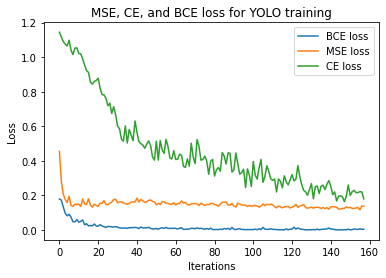

In [ ]:
#plot losses

plt.plot(bce_loss_list[2:], label = "BCE loss")
plt.plot(mse_loss_list[2:], label = "MSE loss")
plt.plot(ce_loss_list[2:], label = "CE loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MSE, CE, and BCE loss for YOLO training")
plt.legend()

in val dataloader iteration 0
0
in val dataloader iteration 1
0
in val dataloader iteration 2
0
in val dataloader iteration 3
0
in val dataloader iteration 4
0
in val dataloader iteration 5
0
in val dataloader iteration 6
0
in val dataloader iteration 7
0
in val dataloader iteration 8
0
in val dataloader iteration 9
0


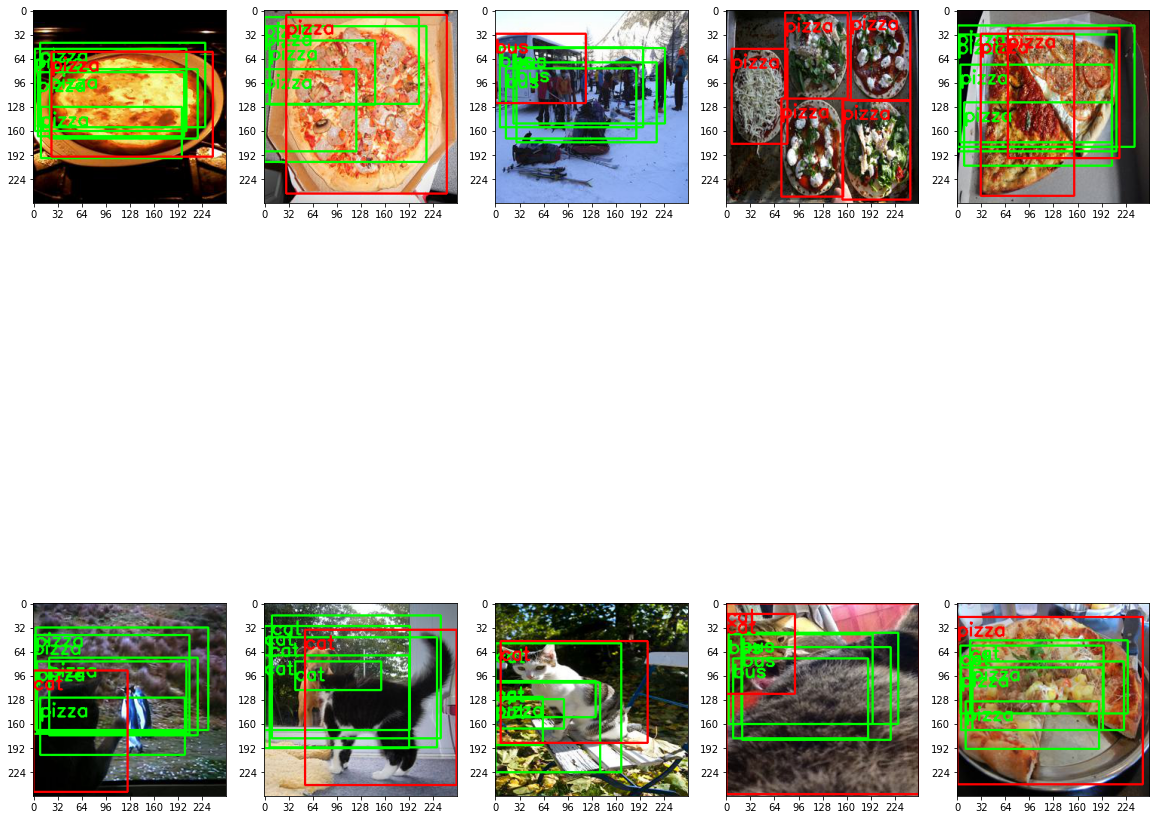

In [ ]:
#eval code:
#iterate over validation dataset, get predictions with "objectness" and plot the corresponding pred classification 
#and bbox and the GT pred/bbox.
count_objects = 0
class_mapping = {0: 'bus', 1: 'cat', 2: 'pizza'}
fig, ax = plt.subplots(2,5, figsize=(20,20))
with torch.no_grad():
    for n, data in enumerate(val_dataloader):
        if n < 10:
            max_obj_count = 0
            print("in val dataloader iteration", n)
            #print("STARTING EVAL CODE")
            images, GT_yolo_tensor, grid_info = data
            images = images.to(torch.device("cuda:0"))
            GT_yolo_tensor = GT_yolo_tensor.to(torch.device("cuda:0"))

            #bbox_label = ops.box_convert(bbox_label, in_fmt = 'xyxy', out_fmt = 'cxcywh')
            pred_yolo_tensor = test_net(images)
            pred_yolo_tensor = torch.reshape(pred_yolo_tensor, (8,8, 5, 8))
            GT_yolo_tensor = torch.reshape(GT_yolo_tensor, (8, 8, 5, 8))


            #open image, put into numpy fmt
            img_np = np.array(images.squeeze(dim = 0).cpu())
            img_np = img_np.transpose(1,2,0)
            img_PIL = Image.fromarray(np.uint8(img_np * 255)) #this was originally a tensor, so, need to unnormalize!! 
            img_np = np.uint8(img_PIL)


            #get maximum probabilities of "objectness of prediction" and once we have found those indices, plot their corresponding bboxes:

            max_objectness = np.zeros((5))
            max_objectness_pos = np.zeros((5,4))
            for i in range(8):
                for j in range(8):
                    for k in range(5):
                        temp_objectness = np.array(nn.Sigmoid()(pred_yolo_tensor[i,j,k,0].cpu()))
                        if (temp_objectness > 0.999):
                            if np.min(max_objectness) < temp_objectness:
                              idx_temp = np.argmin(max_objectness)
                              max_objectness[idx_temp] = temp_objectness #store probability of object if current probability is higher than the lowest probability in the top 5 objects
                              max_objectness_pos[idx_temp] = [i,j,k,0]
                              
                        if (i == 7) and (j == 7) and (k == 4):
                          for num, x in enumerate(max_objectness_pos):
                            #print("MAX objectness is", max_objectness)
                            if np.array_equal(np.zeros((5)), max_objectness):
                              continue #didn't find any objects above threshold!
                            #print("X IS ", x)
                            #print("the max objectnes pos is", max_objectness_pos)
                            #print("max_objectness is", max_objectness)
                            #we know this has a high probability of being an object. Compute h/w to make sure it is a reasonable size.
                            pred_bbox = pred_yolo_tensor[int(x[0]), int(x[1]), int(x[2]), 1:5]

                            center_x = x[0] * 32 + pred_bbox[0] * 32 #predicted yolo cell_x + offset_x from predicted yolo center gives us the predicted center of bbox
                            center_y = x[1] * 32 + pred_bbox[1] * 32 #predicted yolo_cell_y + offset_y from predicted yolo center gives us the predicted center of bbox
                            anchor_mapping = {0: [5,1], 1: [3, 1], 2: [1, 1], 3: [1, 3], 4: [1,5]} #gets from index to w/h of anchor box
                            pred_bbox_w = torch.exp(pred_bbox[2]) * anchor_mapping[x[2]][0] *32 #this value represents which anchor box we are looking at in the prediction.
                            #the above line multiplies the ratio of the GT/anch width by the anchor width by the yolo interval to get the predicted w
                            pred_bbox_h = torch.exp(pred_bbox[3]) * anchor_mapping[x[3]][1] *32
                            #print("pred_bbox_h", pred_bbox_h)
                            if ((pred_bbox_h * pred_bbox_w) < 4096):
                              #print('found an obj too small')
                              continue #object is too small for dataset. 
                            max_obj_count += 1
                            # we have passed test for object size. Convert it to xyxy fmt so bbox can be displayed on image:
                            pred_bbox_real_coords = torch.tensor([center_x, center_y, pred_bbox_w, pred_bbox_h])
                            pred_bbox_xyxy = ops.box_convert(pred_bbox_real_coords, in_fmt = 'cxcywh', out_fmt = 'xyxy')
                            pred_bbox_xyxy = torch.clamp(pred_bbox_xyxy, 0, 256)
                            x1 = int(pred_bbox_xyxy[0])
                            y1 = int(pred_bbox_xyxy[1])
                            x2 = int(pred_bbox_xyxy[2])
                            y2 = int(pred_bbox_xyxy[3])
                            #print(x1, y1, x2, y2)
                            #add bbox to image:
                            img_np = cv2.rectangle(img_np, (x1, y1), (x2, y2), (0,255,0), 2)

                            # #get object classification:
                            #print(pred_yolo_tensor[i, j, k, 5:])
                            pred_class_vector = int(torch.argmax(pred_yolo_tensor[int(x[0]), int(x[1]), int(x[2]), 5:]).cpu())
                            #print("pred_class_vector", pred_class_vector)
                            class_mapping = {0: 'bus', 1: 'cat', 2: 'pizza'}
                            pred_classification = class_mapping[pred_class_vector]
                            #print(pred_classification)
                            img_np = cv2.putText(img_np, pred_classification, (x1, y1 + 25), 
                                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255, 0),2)

            

            ## Plot GT bboxes
            
            GT_yolo_tensor = GT_yolo_tensor.cpu()
            non_zeros = torch.nonzero(GT_yolo_tensor)
            non_zero_idx = torch.nonzero(GT_yolo_tensor[:,:,:,0])
            grid_info = grid_info.squeeze(dim=0)
            ticks = np.linspace(start = 0, stop = 256, num=9)
            for num, i in enumerate(non_zero_idx):
              #print("grid_info", grid_info[:,num])
              x1, y1 = grid_info[3:5,num]
              w,  h  = grid_info[5:7, num]
              class_num = grid_info[-1, num]
              x2 = int(x1 + w)
              y2 = int(y1 + h)
              x1 = int(x1)
              y1 = int(y1)
              img_np = cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)
              GT_bbox = GT_yolo_tensor[i[0], i[1], i[2], 1:5]
              anchor_mapping = {0: [5,1], 1: [3, 1], 2: [1, 1], 3: [1, 3], 4: [1,5]} #gets from index to w/h of anchor box
              GT_bbox_w = GT_bbox[2] * anchor_mapping[int(i[2])][0] * 32  #this value represents which anchor box we are looking at in the prediction.
              #the above line multiplies the ratio of the GT/anch width by the anchor width by the yolo interval to get the predicted w
              GT_bbox_h = GT_bbox[3] * anchor_mapping[int(i[2])][1] * 32



              img_np = cv2.putText(img_np, class_mapping[int(class_num)], (x1, y1 + 25), 
                                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0, 0),2)
              #print("about to plot image!!! when n is", n)
              if n < 5:
                ax[0,n].set_xticks(ticks)
                ax[0,n].set_yticks(ticks)
                ax[0,n].imshow(img_np)
              if n >4:
                ax[1,n-5].set_xticks(ticks)
                ax[1,n-5].set_yticks(ticks)
                ax[1,n-5].imshow(img_np)

            

        if n > 10:
            break
#print(count)

In [ ]:
#argmax test:

test_arr = np.zeros((2, 3,2,8))
test_arr[0,0,0, 0] = 1
test_arr[1,1,1, 0] = 2

print(test_arr)

#test_arr = np.array([3, 4, 5 ,6])
print(test_arr[:,:,:,0])
print(np.argmax(test_arr[:,:,:,0]))

[[[[1. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0.]
   [2. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]]]]
[[[1. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 2.]
  [0. 0.]]]
9
